# Setup

In [1]:
from google.colab import drive
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Pipeline


In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:

file_path = "/content/drive/MyDrive/24fall_dlProject/data/BTC-USD_stock_data_with_indicators.csv"

data = pd.read_csv(file_path,index_col='Date',parse_dates=['Date'])
data.head()

,Open,High,Low,Close,Adj Close,Volume,SMA (fast),SMA (middle),SMA (slow),RSI (slow),RSI (middle),RSI (fast),K,D,J,OBV,BIAS (slow),BIAS (middle),BIAS (fast)
Date,,,,,,,,,,,,,,,,,,,
2017-01-01,963.658020,1003.080017,958.698975,998.325012,998.325012,147775008,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2017-01-02,998.617004,1031.390015,996.702026,1021.750000,1021.750000,222184992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,222184992,NaN,NaN,NaN
2017-01-03,1021.599976,1044.079956,1021.599976,1043.839966,1043.839966,185168000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,407352992,NaN,NaN,NaN
2017-01-04,1044.400024,1159.420044,1044.400024,1154.729980,1154.729980,344945984,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,752298976,NaN,NaN,NaN
2017-01-05,1156.729980,1191.099976,910.416992,1013.380005,1013.380005,510199008,1046.404993,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,242099968,NaN,NaN,-3.156043


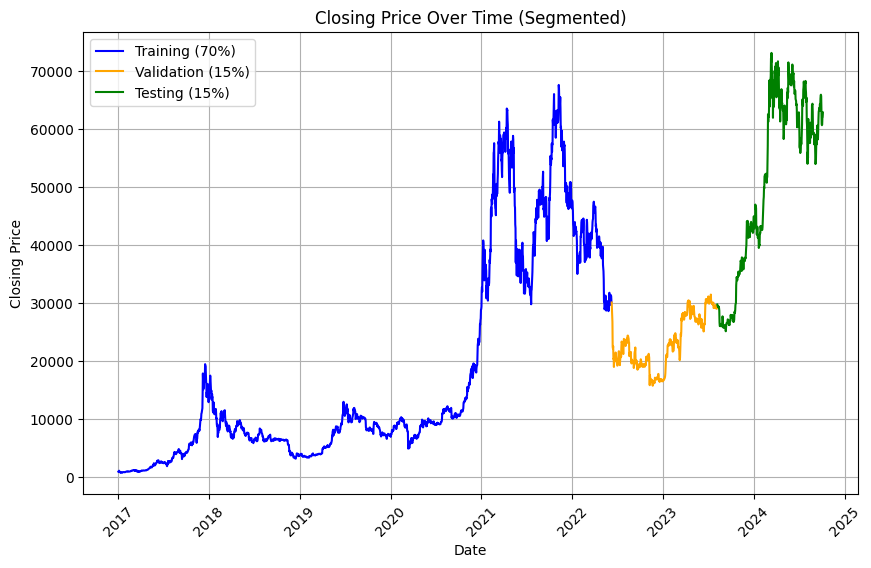

In [5]:
close_data = data['Close'].values  # Get 'Close' data as a NumPy array
total_data_points = len(close_data)
segment1_end = int(total_data_points * 0.7)
segment2_end = int(total_data_points * (0.7 + 0.15))

plt.figure(figsize=(10, 6))

# Plotting segments with different colors
plt.plot(data.index[:segment1_end], close_data[:segment1_end], label='Training (70%)', color='blue')
plt.plot(data.index[segment1_end:segment2_end], close_data[segment1_end:segment2_end], label='Validation (15%)', color='orange')
plt.plot(data.index[segment2_end:], close_data[segment2_end:], label='Testing (15%)', color='green')

plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.title('Closing Price Over Time (Segmented)')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [6]:
def data_preprocessing_with_closed_price_and_min_max_scaler(data, seq_length=60):
    train_ratio = 0.7
    val_ratio = 0.15
    new_data = data.drop(columns=["Adj Close", "Open", "High", "Low", "Volume"])
    close_data = new_data.values.reshape(2836, 14)
    scaler = MinMaxScaler(feature_range=(0, 10))
    data_scaled = scaler.fit_transform(close_data)
    data_scaled = pd.DataFrame(data_scaled)

    def create_feature_datasets(data, x_size):
        x_datasets = []
        y_datasets = []
        for i in range(len(data) - x_size):
            x = data[i:i + x_size].values.reshape(-1, 14)
            y = data[i + x_size:i + x_size + 1][0].values.reshape(1)
            x_datasets.append(x)
            y_datasets.append(y)
        X = np.array(x_datasets)
        y = np.array(y_datasets)
        X_train =  X[23:int(len(X) * train_ratio)]
        y_train = y[23:int(len(y) * train_ratio)]
        X_val = X[int(len(X) * train_ratio):int(len(X) * (train_ratio + val_ratio))]
        y_val = y[int(len(y) * train_ratio):int(len(y) * (train_ratio + val_ratio))]
        X_test = X[int(len(X) * (train_ratio + val_ratio)):]
        y_test = y[int(len(y) * (train_ratio + val_ratio)):]

        indices = np.arange(X_train.shape[0])
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]

        return torch.Tensor(X_train_shuffled).to(device), torch.Tensor(X_val).to(device), torch.Tensor(X_test).to(device), torch.Tensor(y_train_shuffled).to(device), torch.Tensor(y_val).to(device), torch.Tensor(y_test).to(device)

    return create_feature_datasets(data_scaled, seq_length), scaler

(X_train, X_val, X_test, y_train, y_val, y_test), min_max_scaler = data_preprocessing_with_closed_price_and_min_max_scaler(data, 60)

# Baseline Model

In [7]:
# LSTM Model
class LSTM_Decoder_only_Model(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTM_Decoder_only_Model, self).__init__()
        self.lstm = nn.LSTM(input_size-13, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial cell state
        out, _ = self.lstm(x[:, :, 0].unsqueeze(-1), (h_0, c_0))
        out = self.fc(out[:, -1, :])  # Get the output from the last time step
        return out

In [8]:
# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.encoder = nn.LSTM(input_size-1, hidden_size, num_layers, batch_first=True, dropout= 2.5 * dropout)
        self.decoder = nn.LSTM(1, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial hidden state
        c_0 = torch.zeros(num_layers, x.size(0), hidden_size).to(device)  # Initial cell state
        # Encoder: Use all features except the first one
        encoder_input = x[:, :, 1:]  # Shape: (batch_size, seq_len, input_size-1)
        _, (h, c) = self.encoder(encoder_input, (h_0, c_0))
        # Decoder: Use the first feature as input
        decoder_input = x[:, :, 0].unsqueeze(-1)  # Shape: (batch_size, seq_len, 1)
        decoder_output, _ = self.decoder(decoder_input, (h, c))
        out = self.fc(decoder_output[:, -1, :])  # Get the output from the last time step
        return out

# Training

In [9]:
# create a nn class (just-for-fun choice :-)
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [10]:
# Hyperparameters
input_size = 14
hidden_size = 64
num_layers = 2
dropout = 0.1
output_size = 1


learning_rate = 0.00001
num_epochs = 200
batch_size = 4

# Create dataset and DataLoader for batching
dataset = TensorDataset(X_train, y_train)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model, loss, optimizer
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
model.to(device)
criterion = RMSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pretrained_decoder = LSTM_Decoder_only_Model(input_size, hidden_size, num_layers, output_size, dropout)
pretrained_decoder.load_state_dict(torch.load('/content/drive/MyDrive/24fall_dlProject/pretrained_model/decoder_model.pth'))
model.decoder.load_state_dict(pretrained_decoder.lstm.state_dict())

epoch_losses = []

# Training loop with batching
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (batch_x, batch_y) in enumerate(dataloader):
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        predictions = model(X_val)
    rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))

    epoch_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {rmse.item():.4f}')


<ipython-input-10-ed368dc3e398>:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_decoder.load_state_dict(torch.load('/content/drive/MyDrive/24fall_dlProject/pret

Epoch [10/200], Training Loss: 1.0855, Validation Loss: 0.3396
Epoch [20/200], Training Loss: 0.7480, Validation Loss: 0.1742
Epoch [30/200], Training Loss: 0.3735, Validation Loss: 0.1197
Epoch [40/200], Training Loss: 0.0432, Validation Loss: 0.1058
Epoch [50/200], Training Loss: 0.1000, Validation Loss: 0.1150
Epoch [60/200], Training Loss: 0.1915, Validation Loss: 0.1362
Epoch [70/200], Training Loss: 0.0237, Validation Loss: 0.1108
Epoch [80/200], Training Loss: 0.0673, Validation Loss: 0.1150
Epoch [90/200], Training Loss: 0.0242, Validation Loss: 0.1034
Epoch [100/200], Training Loss: 0.1712, Validation Loss: 0.1008
Epoch [110/200], Training Loss: 0.0773, Validation Loss: 0.1125
Epoch [120/200], Training Loss: 0.1780, Validation Loss: 0.1112
Epoch [130/200], Training Loss: 0.0830, Validation Loss: 0.1105
Epoch [140/200], Training Loss: 0.1524, Validation Loss: 0.1312
Epoch [150/200], Training Loss: 0.0480, Validation Loss: 0.0985
Epoch [160/200], Training Loss: 0.1571, Validatio

# Visualization

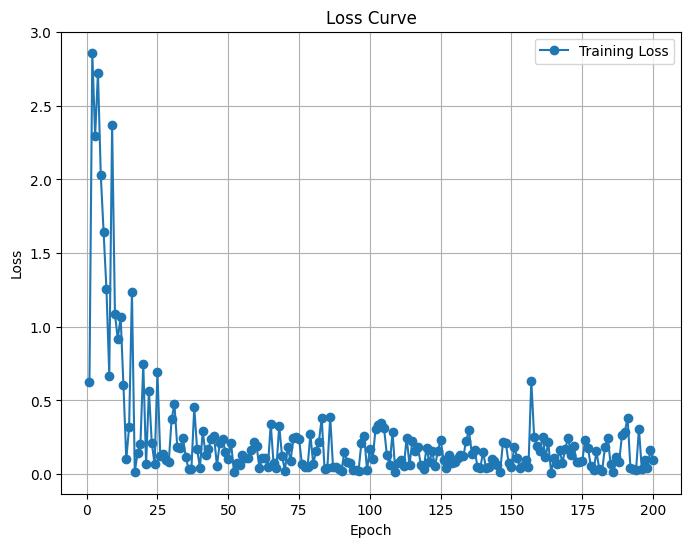

In [11]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), epoch_losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.grid()
plt.show()

In [12]:
model.eval()
with torch.no_grad():
    predictions = model(X_train)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')

y_train.to(device)
rmse = torch.sqrt(torch.mean((predictions - y_train) ** 2))
print(f"Training Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_train_cpu = y_train.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), input_size, axis=1)))[:, 0]
y_train_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_train_cpu.numpy(), input_size, axis=1)))[:, 0]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_train_reversed) ** 2))
print(f"Training Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 0.1596
Training Loss Scaling Unreversed: 0.14381316304206848
Training Loss Scaling Reversed: 1039.8516845703125


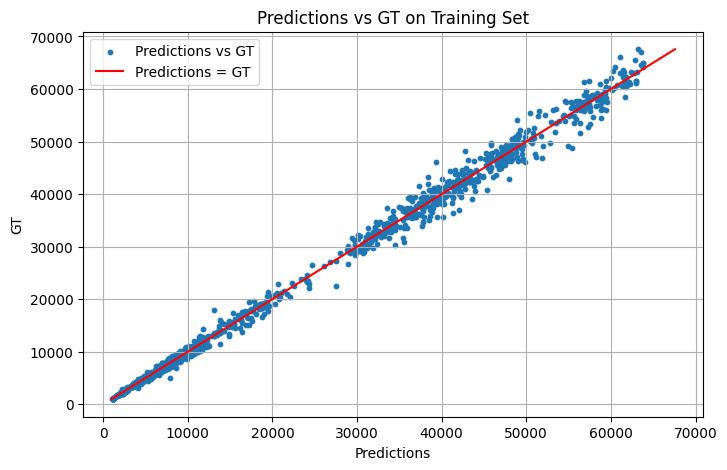

In [13]:

# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.scatter(tensor1.numpy(), tensor2.numpy(), label='Predictions vs GT', marker='o', s=10)

min_val = min(tensor1.min(), tensor2.min())
max_val = max(tensor1.max(), tensor2.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='-', label='Predictions = GT')

plt.title('Predictions vs GT on Training Set')
plt.xlabel('Predictions')
plt.ylabel('GT')
plt.legend()
plt.grid(True)
plt.show()

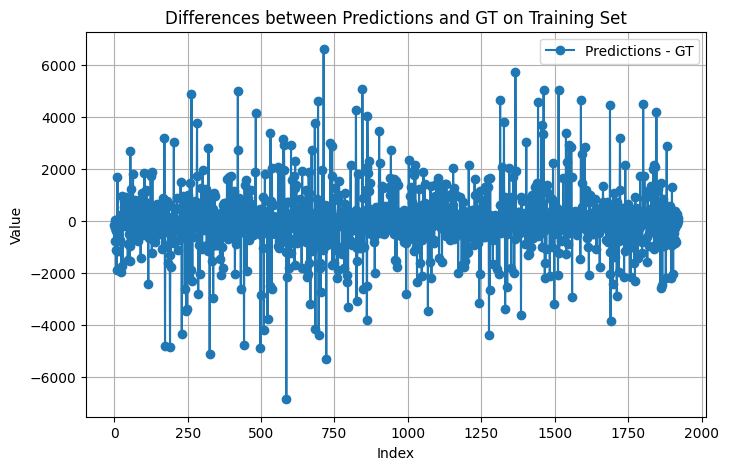

In [14]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_train_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Training Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.eval()
with torch.no_grad():
    predictions = model(X_val)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_val) ** 2))
print(f"Validation Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_val_cpu = y_val.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), input_size, axis=1)))[:, 0]
y_val_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_val_cpu.numpy(), input_size, axis=1)))[:, 0]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_val_reversed) ** 2))
print(f"Validation Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 2.8859
Validation Loss Scaling Unreversed: 0.0995202511548996
Validation Loss Scaling Reversed: 719.588623046875


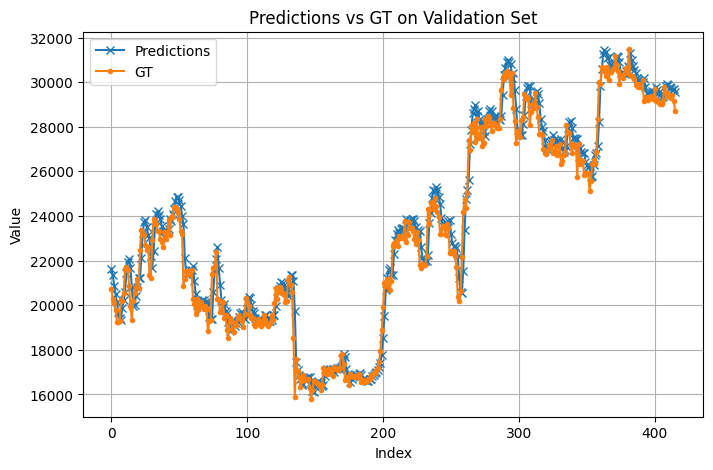

In [16]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.title('Predictions vs GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

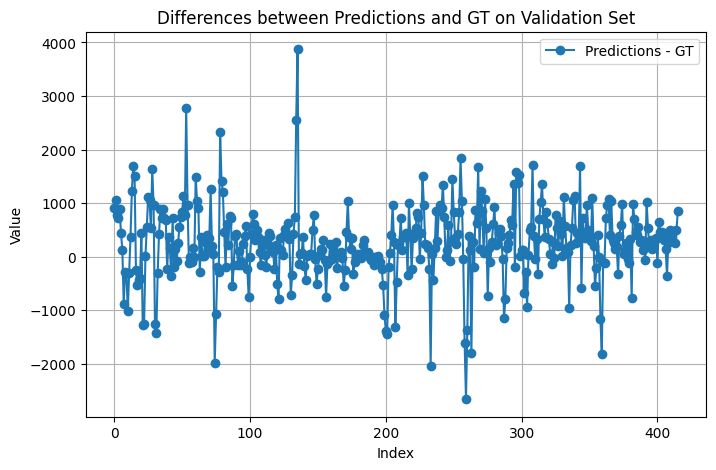

In [17]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_val_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Validation Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    print(f'Predicted value for the first sample: {predictions[0].item():.4f}')
rmse = torch.sqrt(torch.mean((predictions - y_test) ** 2))
print(f"Test Loss Scaling Unreversed: {rmse.item()}")

if device == torch.device("cuda"):
    predictions_cpu = predictions.cpu()
    y_test_cpu = y_test.cpu()

# Reverse the scaling
predictions_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(predictions_cpu.numpy(), input_size, axis=1)))[:, 0]
y_test_reversed = torch.Tensor(min_max_scaler.inverse_transform(np.repeat(y_test_cpu.numpy(), input_size, axis=1)))[:, 0]
rmse_reversed = torch.sqrt(torch.mean((predictions_reversed - y_test_reversed) ** 2))
print(f"Test Loss Scaling Reversed: {rmse_reversed.item()}")

Predicted value for the first sample: 3.9306
Test Loss Scaling Unreversed: 0.5543519258499146
Test Loss Scaling Reversed: 4008.282958984375


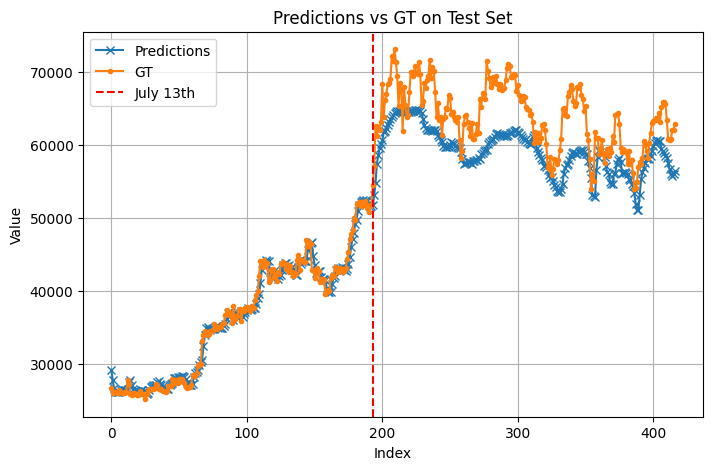

In [26]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_test_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy(), label='Predictions', marker='x')
plt.plot(tensor2.numpy(), label='GT', marker='.')
plt.axvline(x=193, color='red', linestyle='--', label='July 13th')
plt.title('Predictions vs GT on Test Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

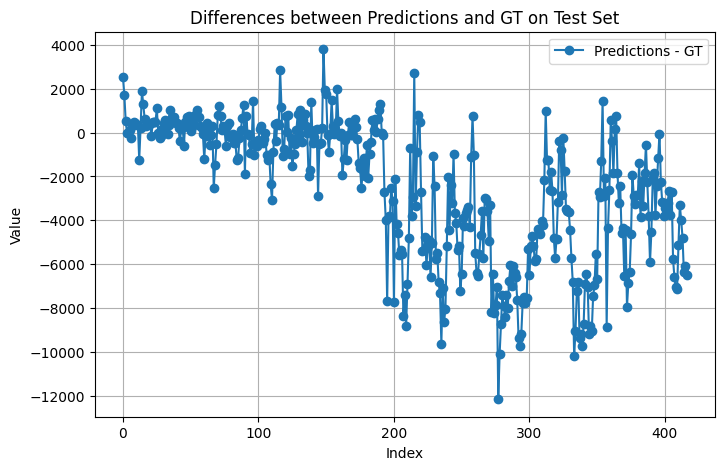

In [20]:
# Convert tensors to 1D for plotting
tensor1 = predictions_reversed.view(-1)
tensor2 = y_test_reversed.view(-1)

# Plotting the line chart
plt.figure(figsize=(8, 5))
plt.plot(tensor1.numpy() - tensor2.numpy(), label='Predictions - GT', marker='o')
plt.title('Differences between Predictions and GT on Test Set')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

# Return

In [21]:
def calculate_daily_long_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_long_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Ensure signals and predicted_prices have compatible shapes for comparison
    signals[:-1] = torch.where(predicted_prices[1:] > predicted_prices[:-1], 1, 0)  # Buy if tomorrow's predicted price > today's
    return signals

  # Trim predicted_prices to match the length of true_prices - 1
  predicted_prices = predicted_prices[:len(true_prices) - 1]  # This ensures both have same dimension for comparison

  signals = generate_daily_trade_signals_long_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[1:] - true_prices[:-1]
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change

  # Ensure both signal and percentage_returns have the same shape before multiplication
  # This addresses the issue by removing the last element from signals
  returns = signals[:-1] * percentage_returns[:-1]  # Both now have length 414

  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

Return: 0.40390777587890625
Max Drawdown: -0.16034041345119476


In [22]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_test_reversed.view(-1)

calculate_daily_long_trade_return_percentage(predicted_prices, true_prices)

Return: 0.23021674156188965
Max Drawdown: -0.42778775095939636


In [23]:
def calculate_daily_short_trade_return_percentage(predicted_prices, true_prices):
  def generate_daily_trade_signals_short_only(predicted_prices, true_prices):
    signals = torch.zeros_like(predicted_prices)
    # Generate a short signal (-1) if tomorrow's predicted price is lower than today's predicted price
    signals[:-1] = torch.where(predicted_prices[1:] < predicted_prices[:-1], 1, 0)
    return signals

  signals = generate_daily_trade_signals_short_only(predicted_prices, true_prices)

  # Calculate price differences and percentage change
  price_diff = true_prices[:-1] - true_prices[1:]  # Since this is a short trade, we reverse the diff
  percentage_returns = (price_diff / true_prices[:-1])  # Convert to percentage change
  # Calculate returns based on signals
  returns = signals[:-1] * percentage_returns
  # Step 1: Calculate cumulative returns
  cumulative_returns = torch.cumprod(1 + returns, dim=0)

  # Step 2: Calculate running maximum of cumulative returns
  running_max, _ = torch.cummax(cumulative_returns, dim=0)

  # Step 3: Calculate drawdowns
  drawdowns = (cumulative_returns - running_max) / running_max

  # Step 4: Find the maximum drawdown
  max_drawdown = drawdowns.min()

  print("Return:", cumulative_returns[-1].item() - 1)
  print("Max Drawdown:", max_drawdown.item())

In [ ]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_val_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

Return: -0.12321048974990845
Max Drawdown: -0.35405343770980835


In [24]:
# Example usage:
predicted_prices = predictions_reversed.view(-1)
true_prices = y_test_reversed.view(-1)

calculate_daily_short_trade_return_percentage(predicted_prices, true_prices)

Return: -0.5385357737541199
Max Drawdown: -0.5974013209342957
